In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import PIL.Image as Image
from keras.applications.mobilenet_v2 import  preprocess_input

In [24]:
train_df=pd.read_csv('.\\chinese-traffic-signs\\annotations.csv')

In [25]:
train_df.head()

,file_name,width,height,x1,y1,x2,y2,category
0,000_0001.png,134,128,19,7,120,117,0
1,000_0002.png,165,151,23,12,149,138,0
2,000_0003.png,128,122,22,14,116,105,0
3,000_0010.png,80,73,14,8,67,63,0
4,000_0011.png,186,174,36,15,155,157,0


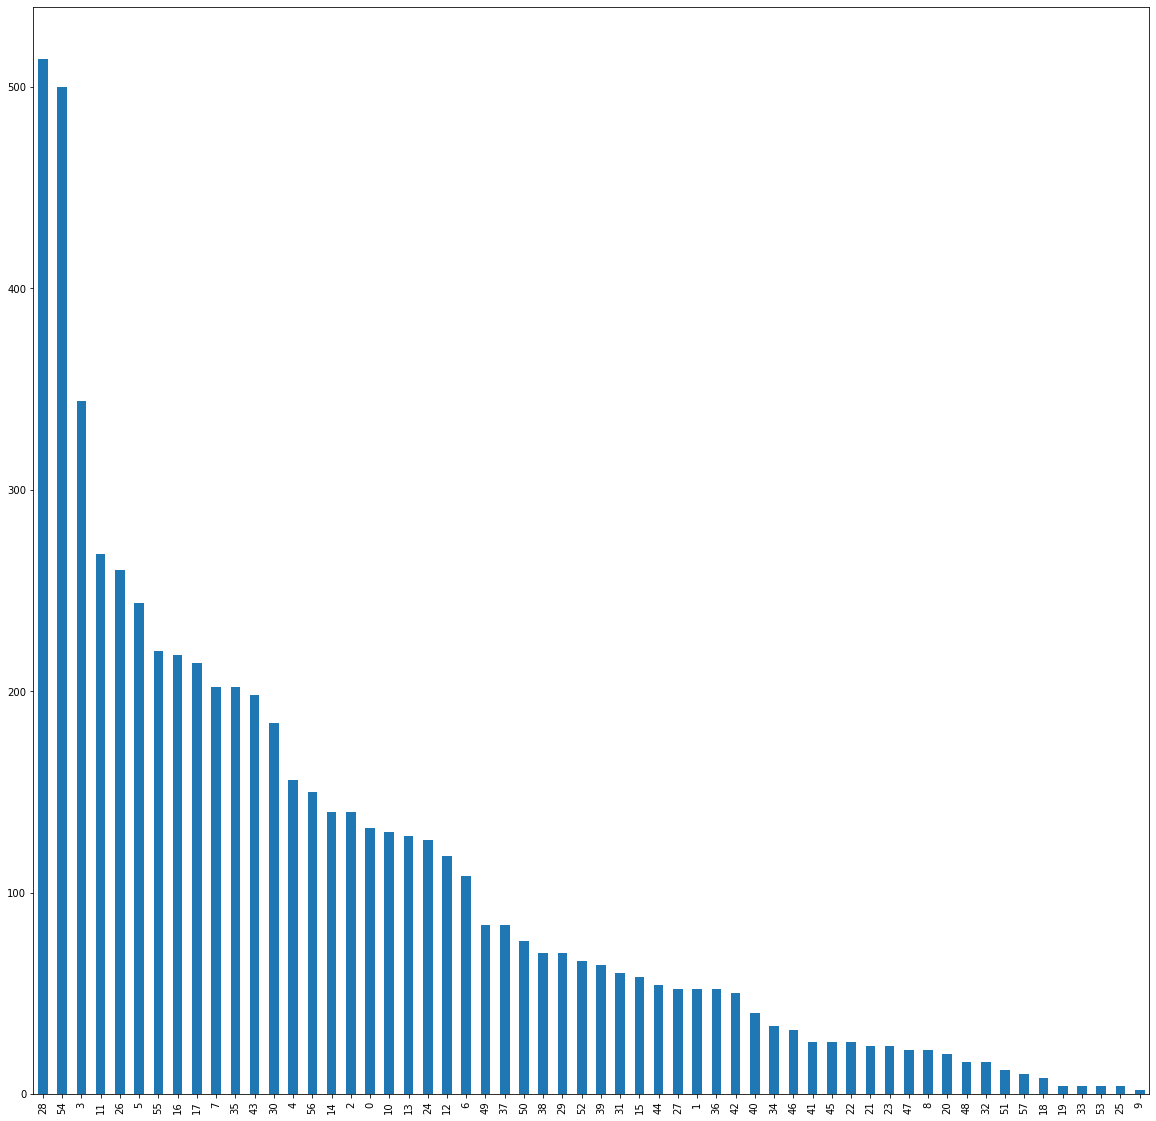

In [26]:
plt.figure(figsize=(20,20))
train_df['category'].value_counts().plot(kind='bar')
plt.show()

In [27]:
train_df['category'] = train_df['category'].astype('str')

In [28]:
from keras.applications.mobilenet_v2 import  preprocess_input
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            
            preprocessing_function=preprocess_input,
            validation_split=0.1,
            featurewise_center=False,
            featurewise_std_normalization=False,
            rotation_range=15,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
            
            )

In [29]:
train_generator = datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=".\\chinese-traffic-signs\images",
            x_col="file_name",
            y_col="category",
            has_ext=False,
            subset="training",
            batch_size=16,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=(224,244))
print('Train generator created')

Found 5548 validated image filenames belonging to 58 classes.
Train generator created


In [30]:
classes=list(train_generator.class_indices.keys())
len(classes)

58

In [31]:
from keras.applications.mobilenet_v2 import  preprocess_input
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            
            preprocessing_function=preprocess_input,
            validation_split=0.1,
            )

In [32]:
val_generator = datagen.flow_from_dataframe(
            dataframe=train_df,
            directory='.\\chinese-traffic-signs\images',
            x_col="file_name",
            y_col="category",
            has_ext=False,
            subset="validation",
            batch_size=16,
            seed=42,
            shuffle=False,
            class_mode="categorical",
            target_size=(224,224))

Found 616 validated image filenames belonging to 58 classes.


### MobileVNet2 model(pre-trained model) 
Source = https://www.kaggle.com/code/hossamfakher/traffic-sign-classification-acc-96/notebook

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

In [12]:
optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [13]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('Trafic_sign.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [14]:
from keras.applications.mobilenet_v2 import MobileNetV2
mb=MobileNetV2(include_top=False,input_shape=(224,224,3),weights='imagenet')

In [15]:
mb.trainable=False

In [16]:
model = Sequential()
model.add(mb)
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 1024 , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 58 , activation = 'softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 512)               32113152  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4

In [18]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=["accuracy"])

In [19]:
history=model.fit(train_generator,validation_data=val_generator,epochs=100,batch_size=16,
                  steps_per_epoch=len(train_generator)//16,validation_steps=len(val_generator)//16,
                  callbacks=callback, verbose=1)

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 3.2723 - accuracy: 0.3244
Epoch 1: val_loss improved from inf to 3.25989, saving model to Trafic_sign.hdf5
21/21 [==============================] - 31s 1s/step - loss: 3.2723 - accuracy: 0.3244 - val_loss: 3.2599 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 2.3779 - accuracy: 0.4494
Epoch 2: val_loss did not improve from 3.25989
21/21 [==============================] - 22s 1s/step - loss: 2.3779 - accuracy: 0.4494 - val_loss: 8.2968 - val_accuracy: 0.0312 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 1.8779 - accuracy: 0.5327
Epoch 3: val_loss did not improve from 3.25989
21/21 [==============================] - 23s 1s/step - loss: 1.8779 - accuracy: 0.5327 - val_loss: 6.4637 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss: 1.6922 - accuracy: 0.5833
Epoch 4: val_lo

21/21 [==============================] - 24s 1s/step - loss: 0.6447 - accuracy: 0.7976 - val_loss: 0.4486 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 29/100
21/21 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.8393
Epoch 29: val_loss improved from 0.19084 to 0.17794, saving model to Trafic_sign.hdf5
21/21 [==============================] - 31s 1s/step - loss: 0.5608 - accuracy: 0.8393 - val_loss: 0.1779 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 30/100
21/21 [==============================] - ETA: 0s - loss: 0.5136 - accuracy: 0.8512
Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 30: val_loss did not improve from 0.17794
21/21 [==============================] - 18s 778ms/step - loss: 0.5136 - accuracy: 0.8512 - val_loss: 0.3638 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 31/100
21/21 [==============================] - ETA: 0s - loss: 0.5356 - accuracy: 0.8393
Epoch 31: val_loss improved from 0.17794 to 0.16259, saving model to Tr

In [20]:
loss,acc=model.evaluate(val_generator)

39/39 [==============================] - 25s 640ms/step - loss: 0.4921 - accuracy: 0.8474


#### The MobileVNet model is not unique. It is inspired from kaggle notebook.
#### I'm going to define a CNN model which train from scratch will classify the traffic signs into 58 categories. I'll try different parameters and layers to see if the model performance and accuracy is better compared to MobileVNet model.

In [72]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(58, activation='softmax')
])

In [73]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [75]:
history_1 = model_1.fit(train_generator,
                    epochs=20,
                    steps_per_epoch=train_generator.samples // 16,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // 16)

# Evaluate the model on the training set
train_loss, train_acc = model_1.evaluate(train_generator, verbose=2)
print('Train accuracy:', train_acc)

# Evaluate the model on the test set
test_loss, test_acc = model_1.evaluate(val_generator, verbose=2)
print('Test accuracy:', test_acc)

Epoch 1/20
346/346 [==============================] - 443s 1s/step - loss: 0.5127 - accuracy: 0.8261 - val_loss: 0.5518 - val_accuracy: 0.7993
Epoch 2/20
346/346 [==============================] - 417s 1s/step - loss: 0.4366 - accuracy: 0.8529 - val_loss: 0.4108 - val_accuracy: 0.8586
Epoch 3/20
346/346 [==============================] - 400s 1s/step - loss: 0.4305 - accuracy: 0.8563 - val_loss: 0.4310 - val_accuracy: 0.8635
Epoch 4/20
346/346 [==============================] - 283s 817ms/step - loss: 0.3665 - accuracy: 0.8736 - val_loss: 0.4279 - val_accuracy: 0.8668
Epoch 5/20
346/346 [==============================] - 370s 1s/step - loss: 0.3597 - accuracy: 0.8832 - val_loss: 0.3764 - val_accuracy: 0.8536
Epoch 6/20
346/346 [==============================] - 353s 1s/step - loss: 0.2979 - accuracy: 0.8973 - val_loss: 0.2687 - val_accuracy: 0.9112
Epoch 7/20
346/346 [==============================] - 338s 975ms/step - loss: 0.2980 - accuracy: 0.9024 - val_loss: 0.2114 - val_accuracy: 

In [78]:
loss_1,acc_1=model_1.evaluate(val_generator)

39/39 [==============================] - 7s 180ms/step - loss: 0.0520 - accuracy: 0.9805


In [77]:
model_1.save('traffic_classifier.h5')

##### This model is CNN model which was uniquely designed by me. After trying different parameters and layers and multiple tries and failures, the model gives better performance compared to MobileVNet model and has better accuracy.

In [33]:
model_3 = tf.keras.models.load_model('Trafic_sign.hdf5')

In [34]:
loss3,acc3=model_3.evaluate(val_generator)

39/39 [==============================] - 13s 297ms/step - loss: 0.4921 - accuracy: 0.8474


In [35]:
model_2 = tf.keras.models.load_model('traffic_classifier.h5')

In [37]:
loss4,acc4=model_2.evaluate(val_generator)

39/39 [==============================] - 4s 103ms/step - loss: 0.0520 - accuracy: 0.9805


In [38]:
print("Accuracy of MobileVNet2 model is ",acc3)

Accuracy of MobileVNet2 model is  0.8474025726318359


In [39]:
print("Accuracy of CNN model is ",acc4)

Accuracy of CNN model is  0.9805194735527039


In [12]:

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    preprocessing_function=preprocess_input
)

image = Image.open('D:\\SUNY UB MS ES DS\\UB MS ES DS SEM 2\\CV_IP(573)\\Project\\\Model_test_images\\000_1_0004_1_j.png')
image = image.resize((224, 224))
image = np.array(image)
image = np.expand_dims(image, axis=0)
image = datagen.flow(image)

In [13]:
category_dict = {0:"Speed limit - 5",1:"Speed limit - 15",2:"Speed limit - 30",3:"Speed limit - 40",4:"Speed limit - 50",5:"Speed limit - 60",
                6:"Speed limit - 70",7:"Speed limit - 80",8:"Only right turn is allowed",9:"Only left turn is allowed",
                10: "No entry, One way" , 11:"No left turn allowed"  , 12: "No left or right turn allowed" , 13: "No right turn allowed"
                ,14: "Cannot change lanes" , 15:"No U-turn allowed" , 16: "No thoroughfare for vehicles",17: "No honking"
                ,18: "End speed limit 40",19: "End speed limit 50",20:"Allowed to go only right or straight", 21: "No turn allowed",
                22:"Only left turn allowed", 23:"Cannot go straight", 24:"Only right turn allowed", 25:"Keep left",
                26:"Keep right", 27:"Roundabout", 28:"Only cars allowed", 29: "Honking allowed",
                30:"Cycle lane", 31:"U-turn allowed",32:"Warning for an obstacle, pass either side", 33:"Traffic signal warning", 
                34:"Warning for a danger with no specific traffic sign.", 35:"Warning for a crossing for pedestrians.", 36: "Warning for cyclists." ,
                37:"Warning for children.", 38:"Warning for a curve to the right.", 39:"Warning for a curve to the left."
                ,40: "Warning for steep descent" ,41: "Warning for steep ascent", 42: "Slow",
                43:"Side road junction ahead on the right", 44:"Side road junction ahead on the left",
                45:"Cross-village road", 46:"Double curve, with turn right first, then left", 
                47:"Locomotive railroad crossing ahead - without safety barriers", 48:"Roadworks ahead",
                49:"Multiple curves", 50: "Railroad head - with safety barriers",
                51:"Accident area", 52:"Stop", 53:"No entry for vehicular and pedestrians", 54:"No stopping",
                55:"No entry for vehicular traffic", 56:"Give way", 57:"Control"}




In [14]:
prediction = model_2.predict(image)
category = np.argmax(prediction)

if category in category_dict.keys():
    print(" Warning -- This model is not perfect, There is a chance of mis-classification")
    print(category_dict[category])
else:
    print("Image does not belong to the pre-defined 58 categories. Please search online.")

1/1 [==============================] - 1s 1s/step
 Warning -- This model is not perfect, There is a chance of mis-classification
Speed limit - 70
